TKO_3120 Machine Learning and Pattern Recognition

Image recognition exercise

Your name <br>
Your e-mail

February 2022

---


This is the template for the image recognition exercise. <Br>
Some **general instructions**:
 - write a clear *report*, understandable for an unspecialized reader: define shortly the concepts and explain the phases you use
    - use the Markdown feature of the notebook for larger explanations
 - return your output as a working Jupyter notebook
 - name your file as MLPR22_exercise_your_surname.ipynb
 - write easily readable code with comments     
     - if you exploit some code from web, provide a reference
     - avoid redundant code! Exploit the relevant parts and modify the code for your purposes to produce only what you need 
 - it is ok to discuss with a friend about the assignment. But it is not ok to copy someone's work. Everyone should submit their own implementation

**Deadline 21st of March at 23:59**
- No extension granted, unless you have an extremely justified reason. In such case, ask for extension well in advance!
- Start now, do not leave it to the last minute. This exercise will need some labour!
- If you encounter problems, Google first and if you can’t find an answer, ask for help
    - pekavir@utu.fi

**Grading**

The exercise covers a part of the grading in this course. The course exam has 5 questions, 6 points of each. Exercise gives 4 points, i.e. the total score is 34 points.

From the template below, you can see how many exercise points can be acquired from each task. Exam points are given according to the table below: <br>
<br>
7-8 exercise points: 1 point <br>
9-10 exercise points: 2 points <br>
11-12 exercise points: 3 points <br>
13-14 exercise points: 4 points <br>
<br>
To pass the exercise, you need at least 7 exercise points, distributed somewhat evenly into tasks (you can't just implement Introduction, Data preparation and Feature extraction and leave the left undone!) <Br>        

## Introduction

<s>Write an introductory chapter for your report **(1 p)**
<br>E.g.
- What is the purpose of this task?
- What kind of data were used? Where did it originate?
- Which methods did you use?</s>

The purpose of this task is to train a machine learning algorithm to identify and classify whether an image is depicting trees, pebbles, or a sky.

- To train our algorithms, images of the aforementioned depictions as data was fed to them.
- The images are in RGB format and they are of many different sizes.
- The images were gathered from https://unsplash.com/.

- To prepare our dataset, the images were resized to the half of the average dimensions of all images.
- After that grayscaled and quantized versions of the images were prepared for richer feature extraction.
- After modifying the images, the dataset size was increased by creating flipped copies of the grayscaled and coloured images.
- Finally we had our default and flipped resized-grayscaled-quantized images and default and flipped resized images.

- From our coloured images, means and variances of all three RGB-channels were extracted.
- From our grayscaled images we created Gray-Level-Co-Occurence matrices and extracted correlations from them as features.
- Also from our grayscaled images we created Gray-Level-Run-Length matrices and extracted Short-Run Emphasis (SRE(, Long-run Emphasis (LRE) and Run Percentage (RP) from them as features

- Machine learning classification algorithms used were K-Nearest Neighbour (kNN), Ridge Regression (RR) and Multi-Level-Perceptron (MLP)
- Heavy reliance on scikit-learn package for Python
- More about the results of our classification at the end of this notebook

## Data preparation

<s>Perform preparations for the data **(3 p)**
- import all the packages needed for this notebook in one cell
- read the URL:s from the text files and import the images
- crop and/or resize the images into same size
- for GLCM and GLRLM, change the images into grayscale and reduce the quantization level to 8 levels
- make data augmentation: flip each image horizontally to increase the number of examples in the data</s>

In [41]:
# gather all packages needed here
import numpy as np
from itertools import groupby
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from tqdm import tqdm
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neural_network import MLPClassifier

In [2]:
# read urls

urls_trees = np.loadtxt('data/trees.txt', dtype='U150')
urls_pebbles = np.loadtxt('data/pebbles.txt', dtype='U150')
urls_sky = np.loadtxt('data/sky.txt', dtype='U150')

In [3]:
# import images

def load_images(data):
    img_data = []
    for img in tqdm(data):
        temp_img = io.imread(img)
        img_data.append(temp_img)
    return img_data

trees_data = load_images(urls_trees)
pebbles_data = load_images(urls_pebbles)
sky_data = load_images(urls_sky)

100%|██████████| 60/60 [00:11<00:00,  5.36it/s]


In [4]:
# extract dimensions for resizing

def extract_dimension(data):
    rows = []
    columns = []
    for img in tqdm(data):
        rows.append(len(img))
        columns.append(len(img[0]))
    return rows, columns

trees_x, trees_y = extract_dimension(trees_data)
pebbles_x, pebbles_y = extract_dimension(pebbles_data)
sky_x, sky_y = extract_dimension(sky_data)

x_dimensions = trees_x + pebbles_x + sky_x
y_dimensions = trees_y + pebbles_y + sky_y

mean_x = np.round(np.mean(x_dimensions) / 2)
mean_y = np.round(np.mean(y_dimensions) / 2)

100%|██████████| 60/60 [00:00<?, ?it/s]


In [5]:
# resize images
# these will be used to gather features from rgb-channels

def resize_images(data):
    resized_images = []
    for img in tqdm(data):
        resized_images.append(resize(img, (mean_x, mean_y)))
    return resized_images

resized_trees = resize_images(trees_data)
resized_pebbles = resize_images(pebbles_data)
resized_sky = resize_images(sky_data)

100%|██████████| 60/60 [00:12<00:00,  4.85it/s]


In [6]:
# grayscale resized images

def grayscale_images(data):
    grayscaled = []
    for img in tqdm(data):
        grayscaled.append(rgb2gray(img))
    return grayscaled

grayscaled_resized_trees = grayscale_images(resized_trees)
grayscaled_resized_pebbles = grayscale_images(resized_pebbles)
grayscaled_resized_sky = grayscale_images(resized_sky)

100%|██████████| 60/60 [00:01<00:00, 38.68it/s]


In [7]:
# quantize grayscaled images

def quantize_images(data, q):
    quantized_images = []
    for img in tqdm(data):
        quantized_images.append(np.round(img*(q-1)).astype(int))
    return quantized_images

quants = 8
quantized_trees = quantize_images(grayscaled_resized_trees, quants)
quantized_pebbles = quantize_images(grayscaled_resized_pebbles, quants)
quantized_sky = quantize_images(grayscaled_resized_sky, quants)

100%|██████████| 60/60 [00:01<00:00, 48.61it/s]


In [8]:
# create flipped images from resized and grayscaled images
# also create labels and groups

def flip_and_label_images(data, id):
    img_id = []
    images = []
    i = 0
    img_labels = []
    for img in tqdm(data):
        img_labels.append(id)
        img_id.append(id + str(i))
        images.append(img)
        img_labels.append(id)
        img_id.append(id + str(i))
        images.append(np.flip(img, 1))
        i += 1
    return images, img_id, img_labels

final_trees, trees_id, trees_labels = flip_and_label_images(quantized_trees, 'trees')
final_pebbles, pebbles_id, pebbles_labels = flip_and_label_images(quantized_pebbles, 'pebbles')
final_sky, sky_id, sky_labels = flip_and_label_images(quantized_sky, 'sky')

rgb_trees, rgb_trees_id, rgb_trees_labels = flip_and_label_images(resized_trees, 'trees')
rgb_pebbles, rgb_pebbles_id, rgb_pebbles_labels = flip_and_label_images(resized_pebbles, 'pebbles')
rgb_sky, rgb_sky_id, rgb_sky_labels = flip_and_label_images(resized_sky, 'sky')

100%|██████████| 60/60 [00:00<00:00, 40342.78it/s]


In [9]:
# prepare dataset for feature extraction

data_gray = final_trees + final_pebbles + final_sky
data_rgb = rgb_trees + rgb_pebbles + rgb_sky
data_id = trees_id + pebbles_id + sky_id
data_labels = trees_labels + pebbles_labels + sky_labels

## Feature extraction

### First order texture measures (6 features)

<s>
- Calculate the below mentioned color features for each image **(1 p)**
    - Mean for each RGB color channel
    - Variance for each RGB color channel
</s>

In [10]:
# calculate mean and var for each rgb color channels

def calc_rgb_means_and_vars(data):
    r_means = []
    g_means = []
    b_means = []
    r_vars = []
    g_vars = []
    b_vars = []
    for img in tqdm(data):
        r_vars.append(np.var(img[:,:,0]))
        r_means.append(np.mean(img[:,:,0]))
        g_vars.append(np.var(img[:,:,1]))
        g_means.append(np.mean(img[:,:,1]))
        b_vars.append(np.var(img[:,:,2]))
        b_means.append(np.mean(img[:,:,2]))
    return r_means, g_means, b_means, r_vars, g_vars, b_vars

# extract features

r_means, g_means, b_means, r_vars, g_vars, b_vars = calc_rgb_means_and_vars(data_rgb)

# gather features

rgb_means_vars = np.transpose(np.array([r_means, g_means, b_means, r_vars, g_vars, b_vars]))

100%|██████████| 360/360 [00:06<00:00, 51.94it/s]


### Second order texture measures (10 features)

<s>- Gray-Level-Co-Occurrence (GLCM) features (4 features) **(2 p)**
    - calculate the "correlation" feature using the GLC matrix
        - in horizontal and vertical directions for two reference pixel distances (you can choose the distances)
    - explain your choice for the distances</s>

In [11]:
# create gray-level-co-occurence matrices
# distances chosen based on dimensions of resized images
# 5 is approximately 1% of image and 25 approximately 5% of image

glcm = []
distances = [5, 25]

for img in tqdm(data_gray):
    glcm.append(graycomatrix(img, distances, [0, np.pi/2], 8))

# calculate correlations

correlations = []

for img in tqdm(glcm):
    correlations.append(graycoprops(img, 'correlation'))

# extract correlations

correlations1 = []
correlations2 = []
correlations3 = []
correlations4 = []

for cor in tqdm(correlations):
    correlations1.append(cor[0,0])
    correlations2.append(cor[0,1])
    correlations3.append(cor[1,0])
    correlations4.append(cor[1,1])

correlations_final = np.transpose(np.array([correlations1, correlations2, correlations3, correlations4]))

100%|██████████| 360/360 [00:00<00:00, 241901.54it/s]


- Gray-Level-Run-Length (GLRL) features (6 features) **(2 p)**
    - Calculate the following three features in horizontal and vertical direction
        - Use the given function for Gray-Level-Run-Length (GLRL) matrix
        - Implement the following run-length features using the GLRL matrix
            - Short-Run emphasis
            - Long-run emphasis
            - Run percentage
        - Test your implementation with the given toy image

In [12]:
# Grey-Level-Run-Length-Matrix

def glrlm(image, levels, angle):
    if angle==0: # horizontal        
        runs=image.shape[1]
        glrl_matrix=np.zeros([levels,runs])

        for row in range(0,image.shape[0]):
            onerow=image[row,:]
            counts=[(i, len(list(g))) for i, g in groupby(onerow)]
            for count in counts:
                glrl_matrix[count[0],count[1]-1]=glrl_matrix[count[0],count[1]-1]+1

    if angle==90: # vertical
        runs=image.shape[0]
        glrl_matrix=np.zeros([levels,runs])

        for column in range(0,image.shape[1]):
            onecolumn=image[:,column]
            counts=[(i, len(list(g))) for i, g in groupby(onecolumn)]
            for count in counts:
                glrl_matrix[count[0],count[1]-1]=glrl_matrix[count[0],count[1]-1]+1
        
    return(glrl_matrix)        

In [13]:
# G_m = gray-level-run-length-matrix
# Np = the number of pixels in the image
def emphasis(G_m, Np):
    
    SRE_sum = 0
    LRE_sum = 0
    RP_sum = 0
    denominator = 0

    N_g = len(G_m)
    N_r = len(G_m[0])

    for i in range(N_g):
        for j in range(N_r):
            denominator += G_m[i,j]
            SRE_sum += G_m[i,j] / (j+1) ** 2
            LRE_sum += G_m[i,j] * (j+1) ** 2
            RP_sum += G_m[i,j]

    SRE = SRE_sum/denominator
    LRE = LRE_sum/denominator
    RP = RP_sum/Np
    
    return(SRE, LRE, RP)

In [14]:
# test the glrlm function with a toy example 1
toy_image=np.array([[1,1,1,2],[2,0,0,1],[1,0,2,2]])

toy_GLRLM_0=glrlm(toy_image,3, 0)
toy_GLRLM_90=glrlm(toy_image,3, 90)

print('GLRL matrix for 0 degrees:')
print(toy_GLRLM_0)
print('GLRL matrix for 90 degrees:')
print(toy_GLRLM_90)

GLRL matrix for 0 degrees:
[[1. 1. 0. 0.]
 [2. 0. 1. 0.]
 [2. 1. 0. 0.]]
GLRL matrix for 90 degrees:
[[1. 1. 0.]
 [5. 0. 0.]
 [4. 0. 0.]]


In [15]:
# test your emphasis function in 0 direction with toy example 1
toy_SRE_0, toy_LRE_0, toy_RP_0=emphasis(toy_GLRLM_0, 12)
print('SRE:', np.round(toy_SRE_0, 3))
print('LRE:', np.round(toy_LRE_0, 3))
print('RP:', np.round(toy_RP_0, 3))

SRE: 0.701
LRE: 2.75
RP: 0.667


In [16]:
# test the emphasis function in 90 direction with toy example 1
toy_SRE_90, toy_LRE_90, toy_RP_90=emphasis(toy_GLRLM_90, 12)
print('SRE:', np.round(toy_SRE_90, 3))
print('LRE:', np.round(toy_LRE_90, 3))
print('RP:', np.round(toy_RP_90, 3))

SRE: 0.932
LRE: 1.273
RP: 0.917


In [17]:
# test the glrlm function with a toy example 2
toy_image=np.array([[1,1,1,2],[2,0,0,1],[1,0,2,2],[0,0,0,0]])

toy_GLRLM_0=glrlm(toy_image,3, 0)
toy_GLRLM_90=glrlm(toy_image,3, 90)

print('GLRL matrix for 0 degrees:')
print(toy_GLRLM_0)
print('GLRL matrix for 90 degrees:')
print(toy_GLRLM_90)

GLRL matrix for 0 degrees:
[[1. 1. 0. 1.]
 [2. 0. 1. 0.]
 [2. 1. 0. 0.]]
GLRL matrix for 90 degrees:
[[4. 0. 1. 0.]
 [5. 0. 0. 0.]
 [4. 0. 0. 0.]]


In [18]:
# test your emphasis function in 0 direction with toy example 2
toy_SRE_0, toy_LRE_0, toy_RP_0=emphasis(toy_GLRLM_0, 16)
print('SRE:', np.round(toy_SRE_0, 3))
print('LRE:', np.round(toy_LRE_0, 3))
print('RP:', np.round(toy_RP_0, 3))

SRE: 0.63
LRE: 4.222
RP: 0.562


In [19]:
# test the emphasis function in 90 direction with toy example 2
toy_SRE_90, toy_LRE_90, toy_RP_90=emphasis(toy_GLRLM_90, 16)
print('SRE:', np.round(toy_SRE_90, 3))
print('LRE:', np.round(toy_LRE_90, 3))
print('RP:', np.round(toy_RP_90, 3))

SRE: 0.937
LRE: 1.571
RP: 0.875


In [20]:
# extract glrl features

glrl_features = []

# loop over
for image in tqdm(data_gray):
    # two glrl matrices
    GLRLM_0 = glrlm(image,quants, 0)
    GLRLM_90 = glrlm(image,quants, 90)
    # features
    SRE_0, LRE_0, RP_0 = emphasis(GLRLM_0, mean_x*mean_y)
    SRE_90, LRE_90, RP_90 = emphasis(GLRLM_90, mean_x*mean_y)
    # collect
    glrl_features.append([SRE_0, LRE_0, RP_0, SRE_90, LRE_90, RP_90])

100%|██████████| 360/360 [01:15<00:00,  4.77it/s]


<s>Gather your features into an input array X, and the image classes into an output array y. Assign an image id for each image so that the original and flipped image have the same id. Standardize the feature values in X.</s>

In [21]:
# gather features

np.array(rgb_means_vars)
np.array(correlations_final)
np.array(glrl_features)
X = np.hstack((rgb_means_vars, correlations_final, glrl_features))
y = data_labels
groups = data_id

In [22]:
# standardization with Z-score
sc = StandardScaler()
X_norm = np.asarray(sc.fit_transform(X))

## Feature relationships

<s>Make illustrations of the feature relationships, and discuss the results **(1 p)**
- Pairplot 
    - Which feature pairs possess roughly linear dependence?</s>

Based on the results below we can see there are some feature pairs that posses high linear dependence
- b_means / g_means
- b_vars / g_vars
- SRE_90 / SRE_0
- RP_90 / RP_0

<AxesSubplot:>

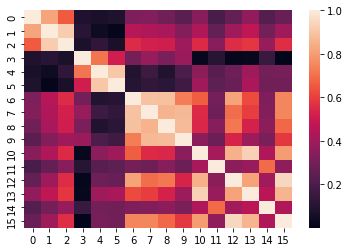

In [23]:
feature_correlations = np.corrcoef(np.transpose(X_norm))
sns.heatmap(np.abs(feature_correlations))

[[1, 2], [4, 5], [10, 13], [12, 15]]


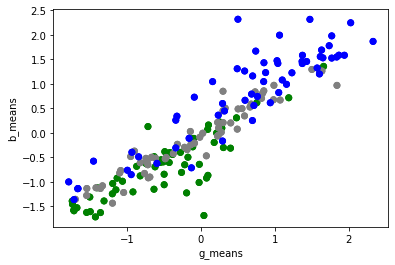

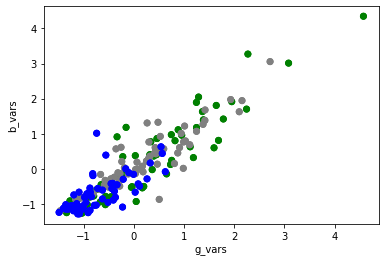

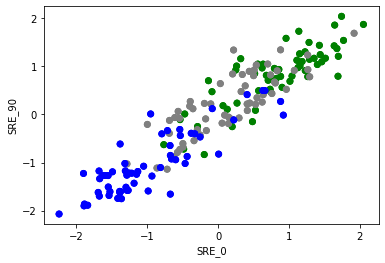

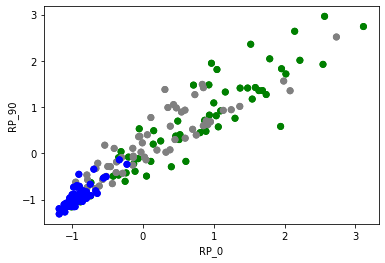

In [40]:
linear_dependent = []
for f in range(len(feature_correlations)):
    for g in range(len(feature_correlations[f])):
        if feature_correlations[f][g] > 0.9 and f != g:
            if [f,g] in linear_dependent or [g,f] in linear_dependent:
                continue
            else:
                linear_dependent.append([f, g])

cdict = {'pebbles': 'gray', 'sky': 'blue', 'trees': 'green'}
feature_names = ['r_means', 'g_means', 'b_means', 'r_vars', 'g_vars', 'b_vars', 'cor1hor', 'cor2hor', 'cor3ver', 'cor4ver', 'SRE_0', 'LRE_0', 'RP_0', 'SRE_90', 'LRE_90', 'RP_90']
c = [*map(cdict.get, y)]

print(linear_dependent)

for i in range(len(linear_dependent)):
    plt.scatter(X_norm[:, linear_dependent[i][0]], X_norm[:,linear_dependent[i][1]], c = c)
    plt.xlabel(feature_names[linear_dependent[i][0]])
    plt.ylabel(feature_names[linear_dependent[i][1]])
    plt.show()
    plt.close()



<s>- PCA
    - Can you see any clusters in PCA?
    - Does this figure give you any clues, how well you will be able to classify the image types? Explain. </s>


Based on the results below we can predict that the results for predicting the sky class will have higher accuracy due it having a clearer cluster on the scatter plot.

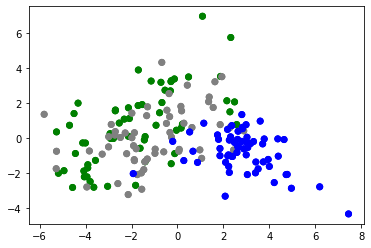

In [25]:
pca = PCA(n_components=2)
transformed = np.transpose(pca.fit_transform(X_norm))

cdict = {'pebbles': 'gray', 'sky': 'blue', 'trees': 'green'}
c = [*map(cdict.get, y)]

plt.scatter(transformed[0], transformed[1], c = c, label = y)
plt.show()

## Build the classifiers and estimate their performance

Build the classifiers and estimate their perfomance. Use LeaveOneGroupOut or GroupKFold cross validator (image id as group indicator).
- k Nearest Neighbors classifier **(1 p)** 
    - optimize the hyperparameter (k) and select the best model for the classifier
    - estimate the performance of the model with nested cross validation
    - calculate the accuracy and the confusion matrix



In [26]:
def find_best_k_and_score(X, y, kSet, groups):

    logo = LeaveOneGroupOut()
    best_k = kSet[0]
    best_acc = 0
    acc = []

    for k in kSet:
        temp_preds = []
        temp_tests = []
        for train, test in logo.split(X, y, groups = groups):
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            kNN = KNeighborsClassifier(n_neighbors = k)
            kNN.fit(X_train, y_train)
            y_preds = kNN.predict(X_test)
            temp_preds.append(y_preds)
            temp_tests.append(y_test)
        preds = [i for l in temp_preds for i in l]
        tests = [i for l in temp_tests for i in l]
        acc.append(metrics.accuracy_score(tests, preds))

    for i in range(len(acc)):
        if acc[i] > best_acc:
            best_k = kSet[i]
            best_acc = acc[i]
    return best_k, best_acc

In [27]:
def knn_nlogocv_acc_cf(X, y, groups, n):

    gkf = GroupKFold(n_splits = n)
    acc = []
    cf = []
    kSet = [1, 3, 5, 7, 9, 11]

    for train, test in tqdm(gkf.split(X, y, groups = groups)):
        X_train, X_test = X[train], X[test]
        y_train, y_test = np.array(y)[train], np.array(y)[test]
        groups_train = np.array(groups)[train]
        best_k, best_acc = find_best_k_and_score(X_train, y_train, kSet, groups_train)
        kNN = KNeighborsClassifier(n_neighbors = best_k)
        kNN.fit(X_train, y_train)
        y_preds = kNN.predict(X_test)
        acc.append(metrics.accuracy_score(y_test, y_preds))
        cf.append(metrics.confusion_matrix(y_test, y_preds))
    
    mean_acc = np.mean(acc)
    mean_cf = np.sum(cf, axis = 0)

    return mean_acc, np.round(mean_cf / n).astype(int)

In [28]:
knn_acc, knn_cf = knn_nlogocv_acc_cf(X_norm, y, groups, 6)
print('Accuracy for kNN:\n', knn_acc)
print('Confusion matrix for kNN:\n', knn_cf)

6it [00:06,  1.01s/it]

Accuracy for kNN:
 0.8277777777777778
Confusion matrix for kNN:
 [[16  1  3]
 [ 2 18  0]
 [ 3  2 16]]


- Regularized linear model with Ridge regression **(1 p)**
    - optimize the hyperparameter (alpha) and select the best model for the classifier
    - estimate the performance of the model with nested cross validation
    - calculate the accuracy and the confusion matrix

In [29]:
def find_best_alpha_and_score(X, y, alphaSet, groups):

    logo = LeaveOneGroupOut()
    best_a = alphaSet[0]
    best_acc = 0
    acc = []

    for a in alphaSet:
        temp_ridge_preds = []
        temp_ridge_tests = []
        for i_train, i_test in logo.split(X, y, groups = groups):
            ridge_X_train, ridge_X_test = X[i_train], X[i_test]
            ridge_y_train, ridge_y_test = y[i_train], y[i_test]
            ridge = RidgeClassifier(alpha = a)
            ridge.fit(ridge_X_train, ridge_y_train)
            temp_ridge_preds.append(ridge.predict(ridge_X_test))
            temp_ridge_tests.append(ridge_y_test)
        ridge_preds = [i for l in temp_ridge_preds for i in l]
        ridge_tests = [i for l in temp_ridge_tests for i in l]
        acc.append(metrics.accuracy_score(ridge_tests, ridge_preds))

    for i in range(len(acc)):
        if acc[i] > best_acc:
            best_a = alphaSet[i]
            best_acc = acc[i]
    return best_a, best_acc

In [30]:
def ridge_nlogocv_acc_cf(X, y, groups, n):

    gkf = GroupKFold(n_splits = n)
    acc = []
    cf = []
    alphaSet = np.arange(0, 1, 0.1)

    for j_train, j_test in tqdm(gkf.split(X, y, groups = groups)):
        ridge_X_train, ridge_X_test = X[j_train], X[j_test]
        ridge_y_train, ridge_y_test = np.array(y)[j_train], np.array(y)[j_test]
        groups_train =  np.array(groups)[j_train]
        best_a, best_acc = find_best_alpha_and_score(ridge_X_train, ridge_y_train, alphaSet, groups_train)
        ridge = RidgeClassifier(alpha = best_a)
        ridge.fit(ridge_X_train, ridge_y_train)
        ridge_y_pred = ridge.predict(ridge_X_test)
        acc.append(metrics.accuracy_score(ridge_y_test, ridge_y_pred))
        cf.append(metrics.confusion_matrix(ridge_y_test, ridge_y_pred))
    
    mean_acc = np.mean(acc)
    mean_cf = np.sum(cf, axis = 0)

    return mean_acc, np.round(mean_cf / n).astype(int)

In [31]:
ridge_acc, ridge_cf = ridge_nlogocv_acc_cf(X_norm, y, groups, 6)
print('Accuracy for Ridge regression:\n', ridge_acc)
print('Confusion matrix for Ridge regression:\n', ridge_cf)

6it [00:20,  3.45s/it]

Accuracy for Ridge regression:
 0.8666666666666668
Confusion matrix for Ridge regression:
 [[15  3  3]
 [ 0 19  0]
 [ 1  1 18]]


- Multi-layer perceptron MLP **(1 p)**
    - build the classifier. Use:
        - 1 hidden layer
        - solver for weight optimization: stochastic gradient-based optimizer ('adam')
        - activation function for the hidden layer: rectified linear unit function ('relu')
        - Early stop
    - optimize the number of neurons in the hidden layer and select the best model for the classifier
    - use Early stop committee, i.e. after selecting the model, calculate the prediction for the test data several times with different sampling of the training data. The members of the committee vote for the predicted class of the test sample. Use 50% of the training data for validation (algorithm terminates the training when validation score is not improving)
    - estimate the performance of the classifier with nested cross validation

In [56]:
def find_best_n(X, y, nSet, groups):

    # logo = LeaveOneGroupOut()
    gkf2 = GroupKFold(n_splits = 2)
    best_n = nSet[0]
    best_acc = 0
    acc = []

    for n in nSet:
        temp_mlp_preds = []
        temp_mlp_tests = []
        for i_train, i_test in gkf2.split(X, y, groups = groups):
            mlp_X_train, mlp_X_test = X[i_train], X[i_test]
            mlp_y_train, mlp_y_test = y[i_train], y[i_test]
            mlp = MLPClassifier(hidden_layer_sizes = n, activation = 'relu', solver = 'adam', early_stopping = True)
            mlp.fit(mlp_X_train, mlp_y_train)
            temp_mlp_preds.append(mlp.predict(mlp_X_test))
            temp_mlp_tests.append(mlp_y_test)
        ridge_preds = [i for l in temp_mlp_preds for i in l]
        ridge_tests = [i for l in temp_mlp_tests for i in l]
        acc.append(metrics.accuracy_score(ridge_tests, ridge_preds))

    for i in range(len(acc)):
        if acc[i] > best_acc:
            best_n = nSet[i]
            best_acc = acc[i]
    return best_n, best_acc

In [57]:
def mlp_acc_cf(X, y, groups, n):

    gkf = GroupKFold(n_splits = n)
    acc = []
    cf = []
    nSet = np.arange(100, 1300, 400)

    for j_train, j_test in tqdm(gkf.split(X, y, groups = groups)):
        mlp_X_train, mlp_X_test = X[j_train], X[j_test]
        mlp_y_train, mlp_y_test = np.array(y)[j_train], np.array(y)[j_test]
        groups_train =  np.array(groups)[j_train]
        best_n, best_acc = find_best_alpha_and_score(mlp_X_train, mlp_y_train, nSet, groups_train)
        mlp = MLPClassifier(hidden_layer_sizes = best_n, activation = 'relu', solver = 'adam', early_stopping = True)
        mlp.fit(mlp_X_train, mlp_y_train)
        mlp_y_pred = mlp.predict(mlp_X_test)
        acc.append(metrics.accuracy_score(mlp_y_test, mlp_y_pred))
        cf.append(metrics.confusion_matrix(mlp_y_test, mlp_y_pred))
    
    mean_acc = np.mean(acc)
    mean_cf = np.sum(cf, axis = 0)

    return mean_acc, np.round(mean_cf / n).astype(int)

In [58]:
mlp_acc, mlp_cf = mlp_acc_cf(X_norm, y, groups, 6)
print('Accuracy for MLPn:\n', mlp_acc)
print('Confusion matrix for MLP:\n', mlp_cf)

6it [00:05,  1.03it/s]

Accuracy for MLPn:
 0.7999999999999999
Confusion matrix for MLP:
 [[12  3  5]
 [ 0 19  1]
 [ 1  1 17]]


- Discuss your results **(1 p)**
<br>E.g.
    - Which model performs the best and why?
    - What are the limitations?
    - How could the results be improved?
    - How do you expect the models will perform with unseen data?